#  **Machine Learning Assignment (AUEB 2023-2024)**  
## **5. Multilayer Perceptron (MLP) classification**


---

*Author: Yorgos Velissaridis, yorgos.velissaridis@gmail.com*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

We now tackle the same classification problem as in previous notebooks using a multilayer perceptron (i.e. neural network), which we implement within the pytorch framework.

In [2]:
with open('GTzan_60features_5sec.csv', newline='') as csv_file:
    data = pd.read_csv(csv_file)

X = data.iloc[:,2:62].to_numpy()
y = data.iloc[:,62].to_numpy(dtype=str)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

label_encoder = LabelEncoder()
label_encoder.fit(y)
y_train_encoded = torch.tensor(label_encoder.transform(y_train), dtype=torch.int64)
y_val_encoded = torch.tensor(label_encoder.transform(y_val), dtype=torch.int64)

We create a dataset class to use with pytorch's data loaders:

In [3]:
import torch.utils.data as data

class Dataset(data.Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.data = X
        self.label = y
        self.size = X.shape[0]

    def __len__(self):
      # Number of data points in the dataset
      return self.size

    def __getitem__(self, i):
        # Return the i-th data point of the dataset
        # If there are multiple return values (data point and label), they are returned as a tuple
        data_point = self.data[i]
        data_label = self.label[i]
        return data_point, data_label

We also create an early stopper class that implements early stopping during the training of the MLP:

In [4]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Now we define the MLP class, made up of two hidden layers with dropout, ReLU activation functions and fit and predict methods:

In [5]:
class MPLClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # MLP building blocks
        self.linear1 = nn.Linear(num_inputs, num_hidden[0])
        self.linear2 = nn.Linear(num_hidden[0], num_hidden[1])
        self.linear3 = nn.Linear(num_hidden[1], num_outputs)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # MLP architecture
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

    def fit(self, optimizer, train_data_loader, val_data_loader, loss_module, scheduler=None, early_stopper=None, num_epochs=1000):

        # Initialization of losses per epoch lists, used later for visualizations
        train_losses = []
        val_losses = []

        # Model set to train mode
        self.train()

        # Changes the value of the learning rate at each epoch
        scheduler = scheduler

        # Checks whether validation loss is generally not diminishing and if so, halts training
        early_stopper = early_stopper
        early_stopped = False

        # Training loop
        for epoch in tqdm(range(num_epochs)):

            # Initialization of losses per batch lists, used below to compute losses per epoch
            batch_train_loss = []
            batch_val_loss = []

            # Go through a training set batch
            for data_inputs, data_labels in train_data_loader:

                # Forward pass
                preds = self(data_inputs)

                # Train loss calculation
                loss = loss_module(preds, data_labels)
                batch_train_loss.append(loss.item())

                # Before calculating the gradients, we need to ensure that they are all zero.
                optimizer.zero_grad()
                # Backpropagation algorithm
                loss.backward()

                # Parameter update
                optimizer.step()

            # Go through a validation set batch
            for data_inputs, data_labels in val_data_loader:

                # Forward pass
                preds = self(data_inputs)

                # Validation loss calculation
                batch_val_loss.append(loss_module(preds, data_labels).item())

            # The epoch losses are the means of the batch losses
            epoch_train_loss = np.mean(batch_train_loss)
            epoch_val_loss = np.mean(batch_val_loss)

            train_losses.append(epoch_train_loss)
            val_losses.append(epoch_val_loss)

            # Updates the learning rate
            if scheduler != None:
                scheduler.step()

            # Checks for early stopping
            if early_stopper != None and early_stopper.early_stop(epoch_val_loss):
                early_stopped = True
                print("\nMLP converged at epoch "+str(epoch+1)+", where:")
                print("Training loss   =", epoch_train_loss)
                print("Validation loss =", epoch_val_loss)
                break

        if not early_stopped:
            print("\nMLP didn't converge until epoch "+str(epoch+1)+", the last one, where:")
            print("Training loss =", epoch_train_loss)
            print("Validation loss =", epoch_val_loss)

        return train_losses, val_losses

    def predict(self, x):

        # Model set to evaluation mode
        self.eval()
        # Forward pass
        logits = self(x)
        # Using softmax to compute a probability distribution over target labels
        probabilities = torch.nn.functional.softmax(logits, dim=1)

        # Return the label for which the probability is highest
        return torch.argmax(probabilities, axis=1)

After experimenting with various values, the hyper-parameters below were chosen and used to train the MLP:

In [6]:
# Load train and validation data onto data loaders
train_data_loader = data.DataLoader(Dataset(X_train, y_train_encoded), batch_size=512, shuffle=True)
val_data_loader = data.DataLoader(Dataset(X_val, y_val_encoded), batch_size=512, shuffle=True)

# Initialize mlp classifier object with 160 and 90 units on its
mlp_classifier = MPLClassifier(num_inputs=60, num_hidden=(160, 90), num_outputs=10)

loss_module = nn.CrossEntropyLoss()

# Learning rate
eta = .08
# Max epochs
epochs = 500

optimizer = torch.optim.SGD(mlp_classifier.parameters(), lr=eta, weight_decay=1e-3)

# We use a linear scheduler
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=epochs)

early_stopper = EarlyStopper(5, eta)

train_loss, val_loss = mlp_classifier.fit(optimizer, train_data_loader, val_data_loader,
                                          loss_module, scheduler, early_stopper, epochs)

 34%|███▍      | 169/500 [00:07<00:15, 21.95it/s]


MLP converged at epoch 170, where:
Training loss   = 0.519166959957643
Validation loss = 0.8852855563163757


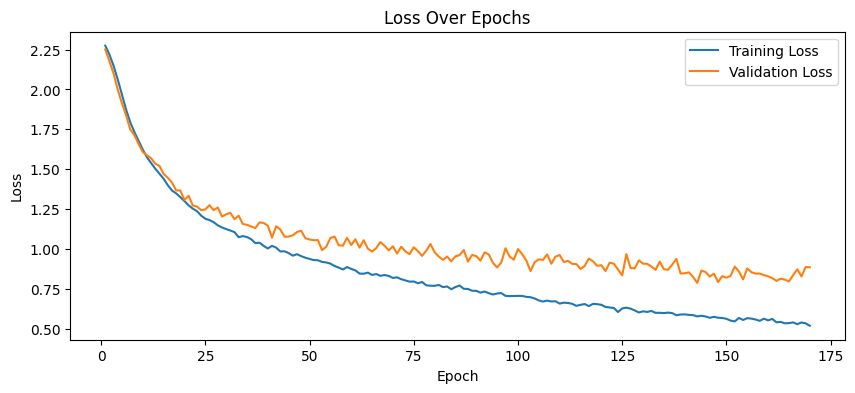

In [7]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

Let's inspect the MLP's performance:

Accuracy on train set: 0.8871331828442438
Accuracy on test set: 0.8040540540540541

Classification Report for our MLP classifier:

              precision    recall  f1-score   support

       blues       0.91      0.94      0.92        32
   classical       0.88      0.92      0.90        25
     country       0.84      0.64      0.72        33
       disco       0.71      0.67      0.69        30
      hiphop       0.97      0.80      0.88        40
        jazz       0.82      0.88      0.85        26
       metal       0.71      0.95      0.82        21
         pop       0.82      0.88      0.85        26
      reggae       0.72      0.82      0.77        34
        rock       0.64      0.62      0.63        29

    accuracy                           0.80       296
   macro avg       0.80      0.81      0.80       296
weighted avg       0.81      0.80      0.80       296



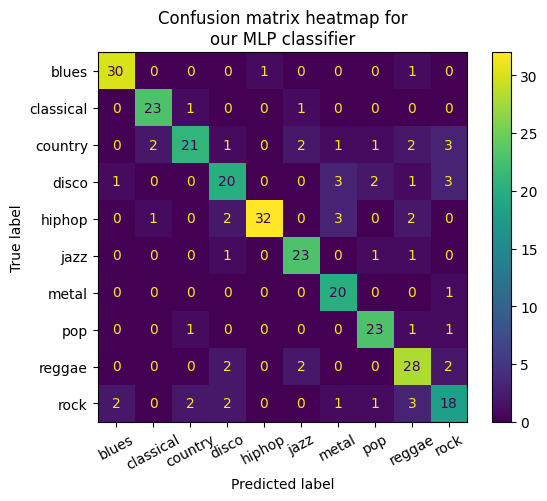

In [8]:
y_pred_train = mlp_classifier.predict(X_train)
y_pred_train_decoded = label_encoder.inverse_transform(y_pred_train)

print("Accuracy on train set:", accuracy_score(y_train, y_pred_train_decoded))

y_pred = mlp_classifier.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print("Accuracy on test set:", accuracy_score(y_test, y_pred_decoded))

class_report = classification_report(y_test, y_pred_decoded)
print("\nClassification Report for our MLP classifier:\n")
print(class_report)

cm = confusion_matrix(y_test, y_pred_decoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig, ax = plt.subplots()
ax.set_title('Confusion matrix heatmap for\nour MLP classifier')
disp.plot(ax=ax)
plt.xticks(rotation=28)
plt.show()

Now, let's compare it to the performance of sklearn's MLPClassifier:

In [9]:
from sklearn.neural_network import MLPClassifier

sk_mlp_classifier = MLPClassifier(max_iter=500, solver='sgd').fit(X_train, y_train)

sk_y_pred = sk_mlp_classifier.predict(X_test)

c:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report for sklearn's MLP classifier:

              precision    recall  f1-score   support

       blues       0.88      0.91      0.89        32
   classical       0.82      0.92      0.87        25
     country       0.82      0.70      0.75        33
       disco       0.69      0.67      0.68        30
      hiphop       0.82      0.80      0.81        40
        jazz       0.84      0.81      0.82        26
       metal       0.69      0.95      0.80        21
         pop       0.88      0.81      0.84        26
      reggae       0.74      0.74      0.74        34
        rock       0.59      0.55      0.57        29

    accuracy                           0.78       296
   macro avg       0.78      0.78      0.78       296
weighted avg       0.78      0.78      0.78       296



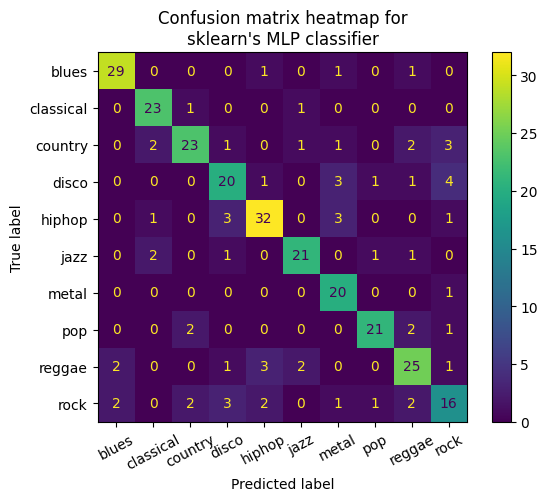

In [10]:
class_report = classification_report(y_test, sk_y_pred)
print("Classification Report for sklearn's MLP classifier:\n")
print(class_report)

cm = confusion_matrix(y_test, sk_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig, ax = plt.subplots()
ax.set_title('Confusion matrix heatmap for\nsklearn\'s MLP classifier')
disp.plot(ax=ax)
plt.xticks(rotation=28)
plt.show()

The two implementations have very similar performance.